In [1]:
import sys
sys.path.append('../../src')
from modules import *
from columns import *
sys.path.append('../../src/python')
from random_funks import *

In [2]:
data=pd.read_csv('../../data/PAH_PCB_OCP.csv',index_col=0)
report=pd.read_csv('../../data/VEGA_report.csv',index_col=0)

In [3]:
report_logP=pd.read_csv('../../data/VEGA_QSAR_modeli/logP_median.csv')

In [4]:
kols=PAH_kol+OCP_kol+PCB_kol

In [5]:
logP=report_logP['logP_median'].values

<Axes: >

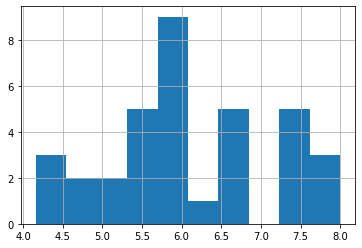

In [6]:
report_logP['logP_median'].hist()

In [7]:
log_Koc= 1.03*logP-0.61

In [8]:
#Koc = 10 ** log_Koc
Koc =np.power(10,log_Koc)

In [9]:
TOC= data['TOC(%)']/100

In [10]:
Kp = np.outer(Koc, TOC)

In [11]:
Kp_array = Kp
konc_array = data.loc[:,kols].values #MJERNE JEDINICE =ng/g
LC50 = report.iloc[:,-1].values #uzet je samo jedan LC50 model, trebam neku srednju vrijednost više modela +MJERNE JEDINICE! =mg/L
LC50_array = LC50 # mg/L

# Proširivanje LC50 da postane matrica dimenzija 35x1
LC50_expanded = LC50_array[:, np.newaxis]
# Broadcasting LC50 preko svih 28 lokacija
LC50_broadcasted = np.tile(LC50_expanded, (1, 28))
# Transponiranje Kp_array da odgovara dimenzijama konc_array
Kp_transposed = Kp_array.T
# Izračunavanje TU
TUsed = konc_array / (Kp_transposed * LC50_broadcasted.T* 10**6)

In [12]:
# Pretpostavimo da imate nazive lokacija i molekula
nazivi_lokacija = [dodaj_nazive_lokacija_i_rijeka(data, i, i) for i in range(len(TUsed))]
nazivi_molekula = kols

TUsed_df = pd.DataFrame(TUsed, index=nazivi_lokacija, columns=nazivi_molekula)

In [13]:
# Dodavanje zbrojenih TU vrijednosti iz TUsed u DataFrame data

data['TU_sed_sum'] = np.sum(TUsed, axis=1)  # Sumiranje TU vrijednosti za svaku lokaciju
# Izračunavanje logaritamske vrijednosti TU_sum
data['TU_site_log10'] = np.log10(data['TU_sed_sum'])

In [14]:
# Stvorite praznu mapu
mapa = folium.Map(location=[data['LAT'].mean(), data['LON'].mean()], zoom_start=10)

# Pripremite podatke za HeatMap
heat_data = [[row['LAT'], row['LON'], row['TU_site_log10']] for index, row in data.iterrows()]
# Dodajte HeatMap na kartu
HeatMap(heat_data).add_to(mapa)

# Dodavanje CircleMarker-a za svaku lokaciju
for index, row in data.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        popup=f"<b>Rijeka:</b> {row['RIJEKA']}<br><b>Naziv postaje:</b> {row['LOKACIJA']}<br><b>TU Site:</b> {round(row['TU_site_log10'], 3)}"
    ).add_to(mapa)

# Prikazuje mapu
#mapa.save('ivana_karta_TU_sum.html')

mapa

In [15]:
# Normalizacija i skaliranje TU_site_log10 vrijednosti
# Ovdje pretpostavljamo da veće log10 TU vrijednosti ukazuju na veću toksičnost

data['TU_site_log10_scaled'] = data['TU_site_log10'] - data['TU_site_log10'].min()
data['TU_site_log10_scaled'] /= data['TU_site_log10_scaled'].max()

In [16]:
# Stvorite praznu mapu
mapa = folium.Map(location=[data['LAT'].mean(), data['LON'].mean()], zoom_start=10)

# Pripremite podatke za HeatMap
heat_data = [[row['LAT'], row['LON'], row['TU_site_log10_scaled']] for index, row in data.iterrows()]

# Dodajte HeatMap na kartu
HeatMap(heat_data, gradient={0.3: 'blue', 0.6: 'lime', 1: 'red'}).add_to(mapa)

# Dodavanje CircleMarker-a za svaku lokaciju
for index, row in data.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        popup=f"<b>Rijeka:</b> {row['RIJEKA']}<br><b>Naziv postaje:</b> {row['LOKACIJA']}<br><b>TU Site:</b> {round(row['TU_site_log10'], 3)}"
    ).add_to(mapa)

# Prikazuje mapu
#mapa.save('ivana_karta_TU_sum.html')
mapa

In [17]:
data['TU_site_log10']

0    -6.284756
1    -6.737839
2    -5.288368
3    -6.915929
4    -7.525967
5    -6.517345
6    -7.364598
7    -6.797515
8    -6.969810
9    -7.112255
10   -7.126974
11   -6.803162
12   -6.725510
13   -5.583713
14   -7.481598
15   -7.397734
16   -6.704811
17   -5.460666
18   -6.528475
19   -6.415635
20   -5.229670
21   -7.127185
22   -7.657584
23   -6.973923
24   -6.945081
25   -7.097256
26   -7.900200
27   -6.860057
Name: TU_site_log10, dtype: float64

In [19]:
# Stvorite praznu mapu
mapa = folium.Map(location=[data['LAT'].mean(), data['LON'].mean()], zoom_start=10)

# Funkcija za određivanje boje na temelju logTU vrijednosti
def get_color(logTU):
    if logTU > -6:
        return 'red' # Veća toksičnost
    elif logTU > -7:
        return 'orange' # Umjerena toksičnost
    else:
        return 'green' # Niska toksičnost

# Funkcija za određivanje radijusa
def get_radius(logTU):
    if logTU > -6:
        return 10  # Veći radijus za veće logTU vrijednosti
    elif logTU > -7:
        return 7   # Srednji radijus
    else:
        return 3   # Manji radijus za manje logTU vrijednosti

# Dodavanje CircleMarker-a za svaku lokaciju
for index, row in data.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=get_radius(row['TU_site_log10']),
        color=get_color(row['TU_site_log10']),
        fill=True,
        fill_color=get_color(row['TU_site_log10']),
        popup=f"Lokacija: {row['LOKACIJA']}<br>logTU: {row['TU_site_log10']:.2f}"
    ).add_to(mapa)

# Prikazuje mapu
mapa.save('ivana_karta_logTU_site.html')
mapa